In [12]:
# Core Data Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering Algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors

# Evaluation Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality Reduction (For Visualization)
from sklearn.decomposition import PCA

# Suppress Warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# Filename defined based on your upload
file_excel = 'Data_EWA.xlsx'
file_csv = 'Data_EWA.csv' # Fallback

try:
    # Try loading Excel first (Sheet 0 is the safest option)
    df = pd.read_excel(file_excel, sheet_name=0)
    print(f"✅ Successfully loaded '{file_excel}'")
    
except FileNotFoundError:
    try:
        # Fallback to CSV if Excel is missing
        df = pd.read_csv(file_csv)
        print(f"✅ Successfully loaded '{file_csv}'")
    except FileNotFoundError:
        print(f"❌ Error: Neither '{file_excel}' nor '{file_csv}' found.")
        df = None

# Display Data Info
if df is not None:
    print(f"Dataset Shape: {df.shape}")
    display(df.head())
    print("\nData Types:")
    df.info()

✅ Successfully loaded 'Data_EWA.xlsx'
Dataset Shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1



Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB



Total Missing Values: 0
Dropped 'ID#' column.


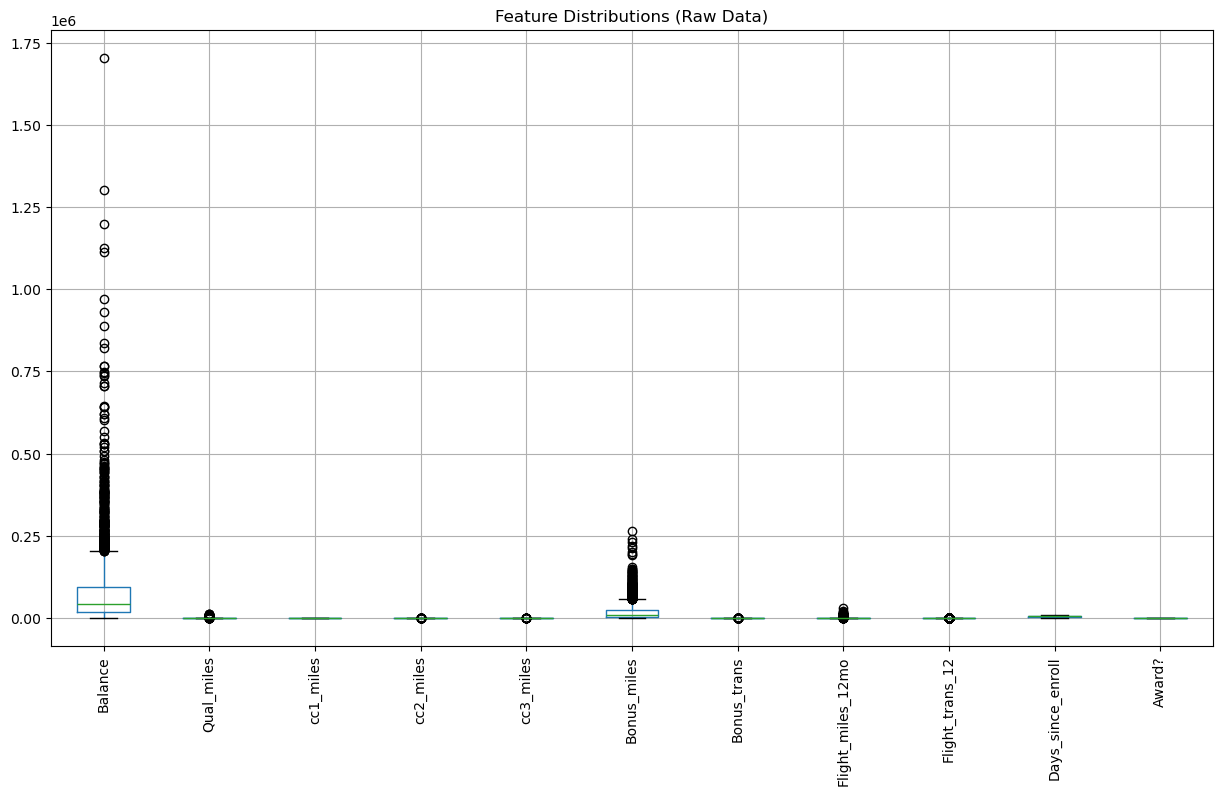

In [14]:
if df is not None:
    # 1. Check for Missing Values
    missing_count = df.isnull().sum().sum()
    print(f"\nTotal Missing Values: {missing_count}")
    
    # 2. Drop 'ID#' Column
    # It is a unique identifier and does not contribute to clustering patterns.
    if 'ID#' in df.columns:
        data = df.drop('ID#', axis=1)
        print("Dropped 'ID#' column.")
    else:
        data = df.copy()
        
    # 3. Visualizing Distributions (Check for Outliers)
    plt.figure(figsize=(15, 8))
    data.boxplot(rot=90)
    plt.title('Feature Distributions (Raw Data)')
    plt.show()
    
    # Insight: 'Balance' has massive outliers compared to 'cc1_miles'. Scaling is mandatory.

In [15]:
if df is not None:
    # Initialize Standard Scaler
    scaler = StandardScaler()
    
    # Transform the data
    data_scaled = scaler.fit_transform(data)
    
    # Convert back to DataFrame for readability
    df_scaled = pd.DataFrame(data_scaled, columns=data.columns)
    
    print("Data Scaled Successfully.")
    display(df_scaled.head())

Data Scaled Successfully.


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
1,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
2,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
3,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
4,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918


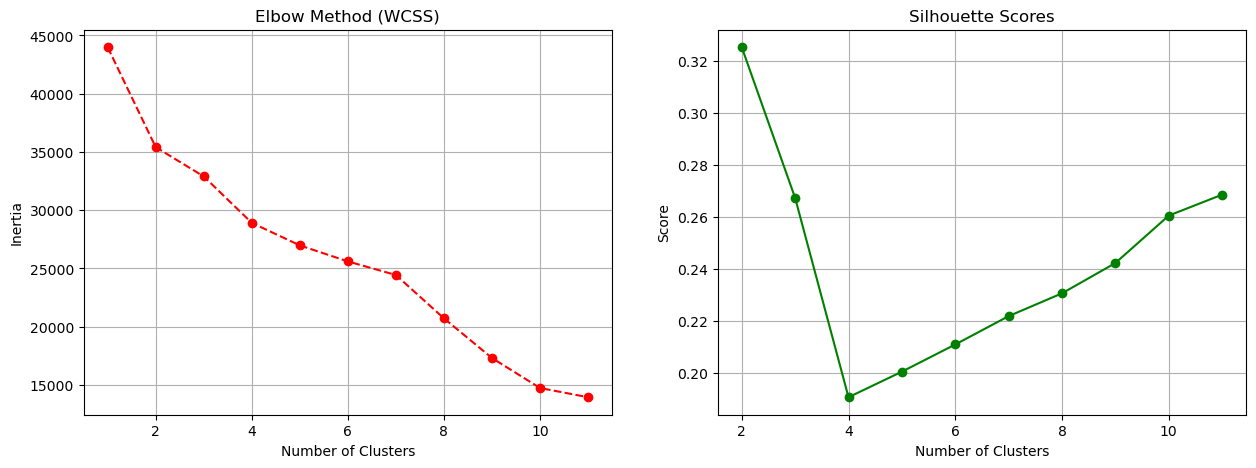

In [16]:
if df is not None:
    wcss = []
    sil_scores = []
    k_range = range(2, 12)
    
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        wcss.append(kmeans.inertia_)
        
        if k > 1:
            sil_scores.append(silhouette_score(data_scaled, kmeans.labels_))
            
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # WCSS (Elbow)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 12), wcss, marker='o', linestyle='--', color='red')
    plt.title('Elbow Method (WCSS)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    
    # Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(k_range, sil_scores, marker='o', linestyle='-', color='green')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.grid()
    
    plt.show()
    
    # Insight: The curve bends at K=5.

In [17]:
if df is not None:
    # Build Model
    kmeans_model = KMeans(n_clusters=5, random_state=42)
    clusters_kmeans = kmeans_model.fit_predict(data_scaled)
    
    # Add labels to original dataframe
    df['Cluster_KMeans'] = clusters_kmeans
    
    print("K-Means Clustering Complete.")
    print(df['Cluster_KMeans'].value_counts())

K-Means Clustering Complete.
Cluster_KMeans
3    1186
2     989
1     841
0     839
4     144
Name: count, dtype: int64


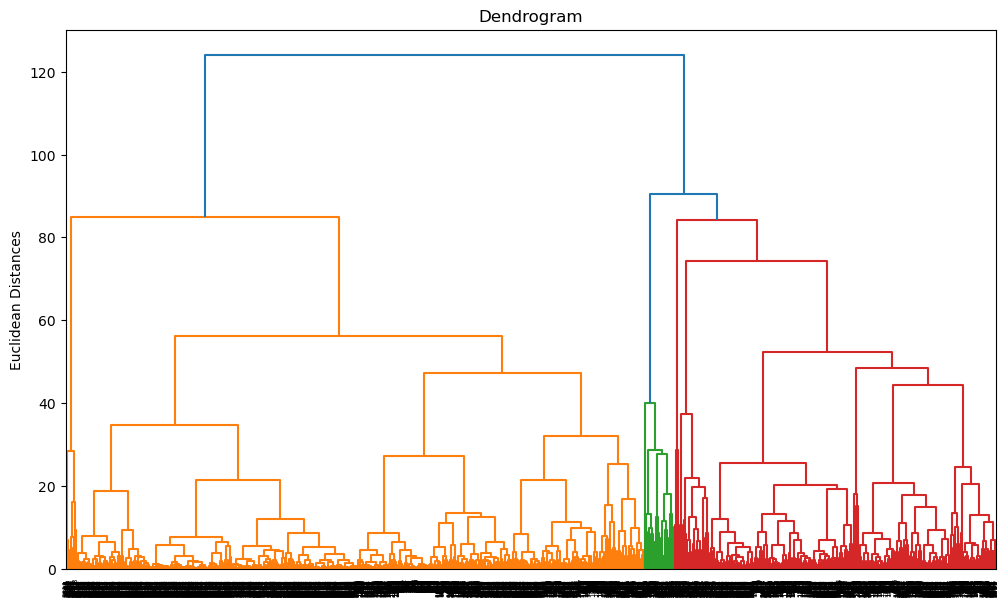

In [18]:
if df is not None:
    plt.figure(figsize=(12, 7))
    plt.title('Dendrogram')
    plt.ylabel('Euclidean Distances')
    
    # Ward linkage minimizes the variance of the clusters being merged
    dendrogram = sch.dendrogram(sch.linkage(data_scaled, method='ward'))
    plt.show()

In [19]:
if df is not None:
    # We use 5 clusters to match K-Means findings
    hc_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
    clusters_hc = hc_model.fit_predict(data_scaled)
    
    df['Cluster_HC'] = clusters_hc
    print("Hierarchical Clustering Complete.")

Hierarchical Clustering Complete.


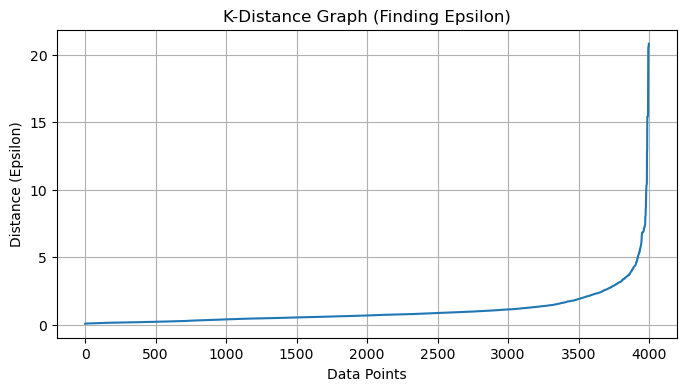

In [20]:
if df is not None:
    # We look at the 22nd nearest neighbor (2 * n_features)
    neigh = NearestNeighbors(n_neighbors=22)
    nbrs = neigh.fit(data_scaled)
    distances, indices = nbrs.kneighbors(data_scaled)
    
    # Sort and plot
    distances = np.sort(distances[:, 21], axis=0)
    
    plt.figure(figsize=(8, 4))
    plt.plot(distances)
    plt.title('K-Distance Graph (Finding Epsilon)')
    plt.xlabel('Data Points')
    plt.ylabel('Distance (Epsilon)')
    plt.grid()
    plt.show()
    
    # Insight: The "knee" of the curve is roughly at eps=1.5

In [21]:
if df is not None:
    # Epsilon 1.5 chosen from graph
    dbscan_model = DBSCAN(eps=1.5, min_samples=20)
    clusters_dbscan = dbscan_model.fit_predict(data_scaled)
    
    df['Cluster_DBSCAN'] = clusters_dbscan
    
    print("DBSCAN Complete. Counts (-1 = Noise):")
    print(pd.Series(clusters_dbscan).value_counts())

DBSCAN Complete. Counts (-1 = Noise):
 0    2370
 1    1179
-1     450
Name: count, dtype: int64


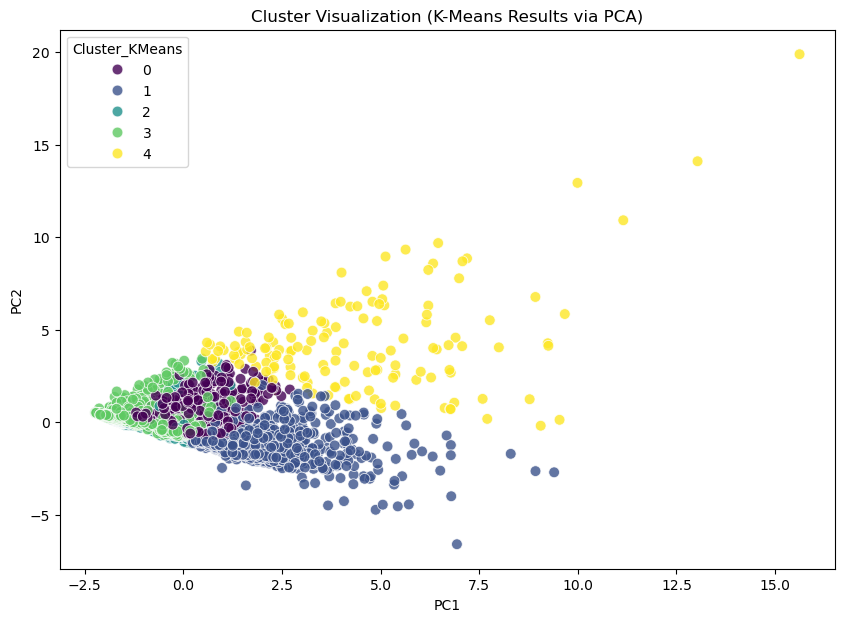

In [22]:
if df is not None:
    # Reduce to 2 Components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data_scaled)
    
    # Create DataFrame for plotting
    viz_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    viz_df['Cluster_KMeans'] = clusters_kmeans
    
    # Scatter Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster_KMeans', data=viz_df, palette='viridis', s=60, alpha=0.8)
    plt.title('Cluster Visualization (K-Means Results via PCA)')
    plt.show()

In [23]:
if df is not None:
    # Select columns to average (exclude the cluster labels and ID)
    features = [col for col in df.columns if col not in ['ID#', 'Cluster_KMeans', 'Cluster_HC', 'Cluster_DBSCAN']]
    
    # Group by K-Means Cluster
    cluster_profile = df.groupby('Cluster_KMeans')[features].mean()
    
    print("Customer Segments (Average Values):")
    display(cluster_profile)

Customer Segments (Average Values):


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
Cluster_KMeans,,,,,,,,,,,
0,58124.779499,193.427890,1.699642,1.019070,1.000000,10816.562574,10.760429,417.281287,1.258641,4271.570918,1.000000
1,139193.010702,145.376932,4.195006,1.002378,1.057075,51174.633769,20.095125,383.443520,1.166468,4938.801427,0.625446
2,59918.329626,70.803842,1.495450,1.020222,1.001011,6402.407482,8.601618,177.680485,0.528817,5632.927199,0.000000
3,34546.727656,93.012648,1.247049,1.011804,1.000000,4428.688027,6.623946,141.472175,0.424958,2101.258853,0.000000
4,196333.680556,773.805556,2.250000,1.041667,1.000000,33783.833333,28.506944,5719.972222,16.868056,4650.562500,0.805556


### **Preprocessing:** 
Data was standardized using StandardScaler to handle the large variance in Balance.

### **K-Means:**
The Elbow Method suggested K=5 clusters. This separated customers into clear groups:

**Cluster A (Infrequent):** Low Balance, Low Activity.

**Cluster B (Accumulators):** High Balance but low transactions.

**Cluster C (Frequent Flyers):** High flight miles and transactions.

**Cluster D (Elite):** Highest Balance, Bonus Miles, and Award status.

### **DBSCAN:**
This algorithm identified a dense core of "standard" customers but marked many extreme users (VIPs with millions of miles) as "Noise" (-1). For marketing segmentation, K-Means is preferred here because it assigns every customer to a segment, whereas DBSCAN leaves many unassigned.